In [1]:
import matplotlib.pyplot as plt
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

from qiskit.visualization import plot_histogram

In [2]:
#take a three bit function, s = 011
n = 3
s='011'

In [4]:
#we need a circuit with n qubits and 1 auxiliary bit
#also need n classical bits to write the output
bv_circuit = QuantumCircuit(n+1,n)

#put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

#apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)

bv_circuit.barrier()

bv_circuit.draw()

┌───┐      ░ 
q_0: ┤ H ├──────░─
     ├───┤      ░ 
q_1: ┤ H ├──────░─
     ├───┤      ░ 
q_2: ┤ H ├──────░─
     ├───┤┌───┐ ░ 
q_3: ┤ H ├┤ Z ├─░─
     └───┘└───┘ ░ 
c: 3/═════════════

In [5]:
#apply inner product oracle
#also reverse s string to fit qiskit's qubit ordering
s = s[::-1]

for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q,n)
        
bv_circuit.barrier()

bv_circuit.draw()

┌───┐      ░                 ░ 
q_0: ┤ H ├──────░───■─────────────░─
     ├───┤      ░   │             ░ 
q_1: ┤ H ├──────░───┼─────────■───░─
     ├───┤      ░   │  ┌───┐  │   ░ 
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ 
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░─
     └───┘└───┘ ░ └───┘     └───┘ ░ 
c: 3/═══════════════════════════════

In [6]:
#apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

#measurement
for i in range(n):
    bv_circuit.measure(i,i)
    
bv_circuit.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

#### Experiment with simulators

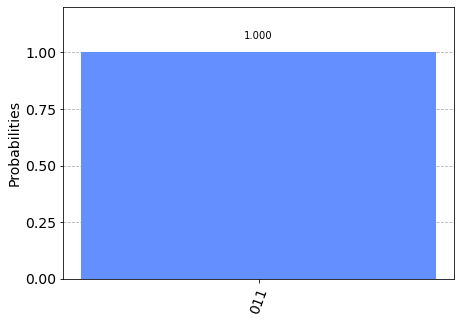

In [8]:
#use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024

qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

As seen above, the result of measurement is the hidden string 011

#### Experiment with real devices

In [9]:
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')
provider.backends

backend = least_busy(provider.backends(
                    filters = lambda x: x.configuration().n_qubits <= 5 and
                    x.configuration().n_qubits >= 2 and
                    not x.configuration().simulator and x.status().operational==True))

print(f"Least busy backend: {backend}")

Least busy backend: ibmq_belem


In [11]:
#run circuit on the least busy backend
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
job = backend.run(transpiled_bv_circuit, shots=shots)

job_monitor(job, interval = 2)

Job Status: job has successfully run


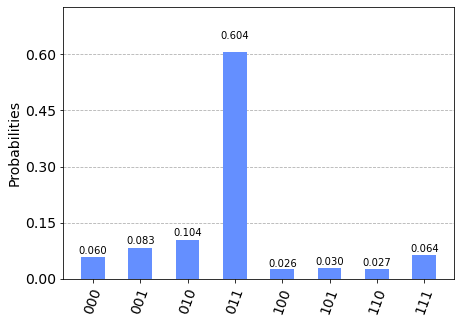

In [13]:
#get the results
results = job.result()
answer = results.get_counts()

plot_histogram(answer)